In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import pandas as pd
from  easydict import EasyDict

In [3]:
import torch
from sklearn.metrics import accuracy_score
import argparse

from predictor import Predictor
from datasets import *
from utils import *
from models import simple_NN

## 각각의 test frame을 추론하고, 50개(1 video = 50frame) frame을 평균내서 가장 높은 값을 가진 클래스를 할당 하는 것

In [15]:
from  easydict import EasyDict
args = EasyDict({
    "BATCH_SIZE" : 32,
    "MODEL_NAME" : 'efficientnet_b0',
    "ENSEMBLE" : None,
    "IMG_PATH" : "./data/div_2width_train/*",
    "CSV_PATH" : "./data/new_test.csv",
    "OUTPUT" : "./results/div_2width_effib0_224.csv",
    "CHECKPOINT" : ["./ckpt/div_2width_effib0_224/1E-val1.0-efficientnet_b0.pth"]
})

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = simple_NN(args.MODEL_NAME, num_classes=13).to(device)
predictor = Predictor(model, device, args)



MODEL LOAD ... from ./ckpt/div_2width_effib0_224/1E-val1.0-efficientnet_b0.pth


In [17]:
preds, pred_inds = predictor.run()

100%|██████████████████████████████████████████████████████████████████████████████████████| 2813/2813 [13:06<00:00,  3.58it/s]


In [ ]:
df = pd.DataFrame({'pred_value' : preds, 'pred_index' : pred_inds})

In [ ]:
pred_list = [0 for i in range(1800)]
cnt = 0
for j in tqdm(range(0, 90000, 50)) :    
    best_score = 0
    best_cls = 0
    for i in range(13) :
        mean_score = sum(df['pred_value'][j : j + 49][df['pred_index'] == i].values)/(len(df['pred_value'][j : j + 50][df['pred_index'] == i].values.tolist()) + +0.000001)
        if mean_score >= best_score  :
            best_score = mean_score
            best_cls = i

    pred_list[cnt] = best_cls
    cnt += 1

In [46]:
df = pd.read_csv("./data/sample_submission.csv")
df['label'] = pred_list

In [51]:
df.to_csv('./results/div_2width_effib0_224.csv', index = False)

## 이미지 channel 단위로 겹치기

In [1]:
import cv2
import os
from glob import glob
import numpy as np
import pandas as pd

import albumentations as A
from albumentations.pytorch import ToTensorV2
# from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
def collate_fn(batch):
    img_stack = []
    label_stack = []
    _transforms = A.Compose([
        A.Resize(384, 384),
        # A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False,
                    p=1.0),
    ])
    print(batch[:][0].shape)
    for img, label in batch:
        # img 나누기
#         w_ratio = int(img.shape[1] / 16)
#         h_ratio = int(img.shape[0] / 8) # 16

        label_stack.append(label)
        label_stack.append(img)
#         for w in range(16):
#             for h in range(8): # 16
#                 cropped_img = _transforms(image=img[h * h_ratio: (h + 1) * h_ratio, w * w_ratio: (w + 1) * w_ratio])['image'].transpose(2, 0, 1)
#                 img_stack.append(cropped_img.tolist())

    return torch.Tensor(img_stack), torch.Tensor(label_stack)

In [3]:
class _ChannelStackDataset(Dataset):
    def __init__(self, _df, labels, transform=None):
        self._df = _df
        self.labels = labels

        self.transform = transform

    def __len__(self):
        return len(self._df)

    def __getitem__(self, index):
        img_path = self._df['img_path'].iloc[index]
        
        # print(img_path)
        # image = cv2.imread(os.path.join('./data', *img_path.split('/')[2:]))
        image = cv2.imread(img_path)

        if self.transform :
            image = self.transform(image=image)['image']
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.labels is not None:
            label = self.labels[index]
            return image, label

        else:
            return image

In [ ]:
# if __name__ == '__main__':
csv_path = "./data/div_2width_train.csv"

df = pd.read_csv(csv_path)
label_set = df['label']
transform = A.Compose([
                A.Resize(224, 224),
                # A.Rotate(limit=(45), p=1),
                # A.RandomGridShuffle(p=grid_shuffle_p, grid=(2,2)),
                A.Normalize(),
                ToTensorV2()
            ])
ds = _ChannelStackDataset(df, label_set, transform)
dl = DataLoader(ds, batch_size=32, shuffle=False, num_workers=1)#, collate_fn=collate_fn)

for img, label in dl :
    print(img.shape)
    print(label.shape)
    break

In [5]:
ds

In [6]:
dl

In [8]:
for img, label in dl :
    print(img.shape)
    print(label.shape)
    break

NameError: name 'dl' is not defined

## timing, weather, ego-involve + crash 학습용 csv 만들기

### timing
- night = 0
- day = 1

In [36]:
path = "./data/50frame_train.csv"
df = pd.read_csv(path)
_df = df[df['label'] != 0]

new_label = [1 if label % 2 == 1 else 0 for label in _df['label'] ]
print("day : ",new_label.count(1))
print("night : ",new_label.count(0))

day :  40400
night :  5350


In [40]:
_df['label'] = new_label

path = "./data/50f_timing_train.csv"
_df.to_csv(path, index=False)

C:\Users\quhb2\AppData\Local\Temp\ipykernel_42468\3172057110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['label'] = new_label


In [132]:
day =  40400
night =  5350
z = [5350, 40400]
np.max(z)/np.array(z)

array([7.55140187, 1.        ])

### weather
- normal = 0
- snowy = 1
- Rainy = 2

In [47]:
path = "./data/50frame_train.csv"
df = pd.read_csv(path)

_df = df[df['label'] != 0]

new_label = []
for label in _df['label'] : 
    
    # normal
    if label in [1,2,7,8] :
        new_label.append(0)
    
    # swnoy
    elif label in [3,4,9,10] :
        new_label.append(1)
    
    # rainy
    elif label in [5,6,11,12] :
        new_label.append(2)
        

print("normal : ",new_label.count(0))
print("swnoy : ",new_label.count(1))
print("rainy : ",new_label.count(2))

normal :  35800
swnoy :  6450
rainy :  3500


In [51]:
_df['label'] = new_label

path = "./data/50f_weather_train.csv"
_df.to_csv(path, index=False)

C:\Users\quhb2\AppData\Local\Temp\ipykernel_42468\279117756.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['label'] = new_label


In [143]:
normal =  35800
swnoy =  6450
rainy =  3500
z = [normal, swnoy, rainy]
np.max(z)/np.array(z)

array([ 1.        ,  5.5503876 , 10.22857143])

### ego-involve + crash 
- No ego + No crash = 0
- No ego + crash = 1
- ego + cash= 2

In [53]:
path = "./data/50frame_train.csv"
df = pd.read_csv(path)

new_label = []
for label in df['label'] :
    # No ego + No crash
    if label == 0 :
        new_label.append(0)
    
    #No ego + crash = 1
    elif label in [7, 8, 9, 10, 11, 12] : 
        new_label.append(1)
    
    # ego + cash = 2
    elif label in [1, 2, 3, 4, 5, 6] :
        new_label.append(2)
    
print("No ego + No crash : ",new_label.count(0))
print("No ego + crash : ",new_label.count(1))
print("ego + cash : ",new_label.count(2))

No ego + No crash :  89150
No ego + crash :  21200
ego + cash :  24550


In [54]:
df['label'] = new_label

path = "./data/50f_EgoCrash_train.csv"
df.to_csv(path, index=False)

In [61]:
import torch
import torch.nn as nn

In [145]:
class FocalLoss(nn.Module) :
    def __init__(self, alpha=2, gamma=2, logits=False, reduction='none') :
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets) :
        ce_loss = nn.CrossEntropyLoss(reduction=self.reduction)(inputs, targets)
        pt = torch.exp(-ce_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * ce_loss

        if self.reduction :
            return torch.mean(F_loss)
        else :
            return F_loss
        
crit = FocalLoss()
# crit = nn.BCEWithLogitsLoss().to(dtype=torch.float)

In [199]:
# a= torch.tensor([1, 0, 0, 0, 0, 1, 1, 1], dtype=torch.float)
a =  torch.tensor([1, 1,  1, 0], dtype=torch.float)
a.shape

torch.Size([4])

In [200]:
b= torch.tensor([[1, 0], [1, 0], [0, 1],[0, 1]], dtype=torch.float)
b.shape

torch.Size([4, 2])

## Ego + crash 모자이크 이미지 만들기
- 앞 쪽 20frame은 빼고 나머지 30frame으로 만들기
- 좌우에서 각각 150px씩 잘라서 만들기

In [3]:
path = "./data/50f_EgoCrash_train.csv"
df = pd.read_csv(path)

In [4]:
df['img_path']

,sample_id,img_path,label
0,TRAIN_0000_000,./data/50frame_train\TRAIN_0000_000.jpg,1
1,TRAIN_0000_001,./data/50frame_train\TRAIN_0000_001.jpg,1
2,TRAIN_0000_002,./data/50frame_train\TRAIN_0000_002.jpg,1
3,TRAIN_0000_003,./data/50frame_train\TRAIN_0000_003.jpg,1
4,TRAIN_0000_004,./data/50frame_train\TRAIN_0000_004.jpg,1
...,...,...,...
134895,TRAIN_2697_045,./data/50frame_train\TRAIN_2697_045.jpg,0
134896,TRAIN_2697_046,./data/50frame_train\TRAIN_2697_046.jpg,0
134897,TRAIN_2697_047,./data/50frame_train\TRAIN_2697_047.jpg,0
134898,TRAIN_2697_048,./data/50frame_train\TRAIN_2697_048.jpg,0


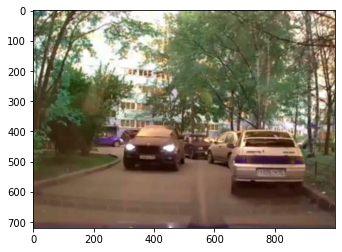

In [8]:
img = cv2.imread('./data/50frame_train\TRAIN_0000_000.jpg')
img = img[:, 140:1140, :]
plt.imshow(img)

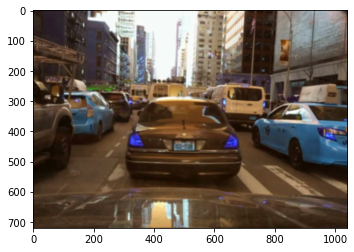

In [15]:

img = cv2.imread('./data/50frame_train\TRAIN_2697_049.jpg')
img = img[:, 120:1160, :]
plt.imshow(img)

In [14]:
1280 - 120 - 200

960

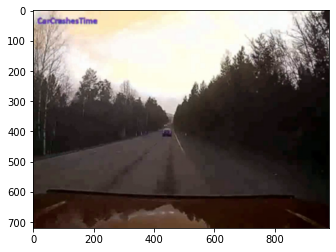

In [20]:

img = cv2.imread('./data/new_test\TEST_1271_029.jpg')
img = img[:, 150:1130, :]
plt.imshow(img)

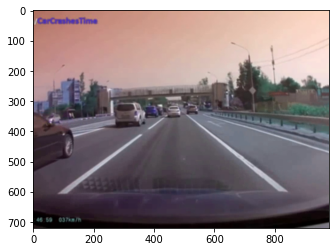

In [21]:


img = cv2.imread('./data/new_test\TEST_1280_006.jpg')
img = img[:, 150:1130, :]
plt.imshow(img)

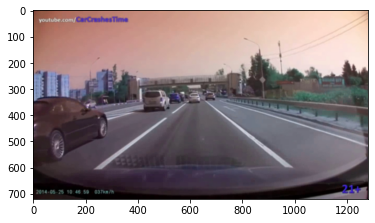

In [22]:


img = cv2.imread('./data/new_test\TEST_1280_006.jpg')
plt.imshow(img)

## triple model predict

In [1]:
import torch
import os
import argparse
from tqdm import tqdm

import numpy as np
from sklearn.metrics import accuracy_score
from torch.utils.tensorboard import SummaryWriter

from datasets import *
from utils import *
from models import simple_NN

In [4]:
from  easydict import EasyDict
args = EasyDict({
    "BATCH_SIZE" : 64,
    "MODEL_NAME" : 'efficientnet_b0',
    "ENSEMBLE" : None,
    "TYPE" : None, 
    "SUBMIT" : "./data/sample_submission.csv",
    "IMG_PATH" : "./data/new_test/*",
    "CSV_PATH" : "./data/new_test.csv",
    "OUTPUT" : "./results/50f_timing_effib0_224.csv",
    "IN_CHANNEL" : 1,
    "CHECKPOINT" : ["./ckpt/50f_timing_effib0_224/3E-val1.0-efficientnet_b0.pth"]
})

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# model_1 = simple_NN(args.MODEL_NAME, num_classes=1).to(device)
# model_1 = weight_load(model_1, None, "./ckpt/50f_timing_effib0_224/3E-val1.0-efficientnet_b0.pth", training=False)
# model_1.eval()

model_2 = simple_NN(args.MODEL_NAME, num_classes=1).to(device)
model_2 = weight_load(model_2, None, args.CHECKPOINT[0], training=False)
model_2.eval()

# model_3 = simple_NN(args.MODEL_NAME, num_classes=3).to(device)
# model_3 = weight_load(model_3, None, "./ckpt/50f_EgoCrash_effib0_224/10E-val0.9275194181147973-efficientnet_b0.pth", training=False)
# model_3.eval()

RuntimeError: Error(s) in loading state_dict for simple_NN:
	size mismatch for model.classifier.weight: copying a param with shape torch.Size([1, 1280]) from checkpoint, the shape in current model is torch.Size([3, 1280]).
	size mismatch for model.classifier.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([3]).

In [4]:
from predictor import Predictor
predictor = Predictor(model_2, device, args)
# preds = predictor.triple_model_predict(model_1, model_2, model_3)
preds, _ = predictor.run()

MODEL LOAD ... from ./ckpt/50f_weather_0.15Normal_PixLevelAug_GridShuffle_effib0_512/9E-val0.993782722513089-efficientnet_b0.pth


100%|██████████| 5625/5625 [08:45<00:00, 10.70it/s]


In [5]:
# preds[0] = list(map(lambda x: int(x[0]), preds[0]))

# display(len(preds[0]))
# display(len(preds[1]))
# display(len(preds[2]))
display(len(preds))

90000

In [6]:
pred_list = []
p2_thrs = 10
p3_thrs = 2
for i in range(0, 90000, 50) :
    # p_1 = np.argmax([preds[0][i : i+50].count(0), preds[0][i : i+50].count(1)])
    
    # p_2 = np.argmax([preds[1][i : i+50].count(0), preds[1][i : i+50].count(1), preds[1][i : i+50].count(2)])
    # if preds[1][i : i+50].count(1) > p2_thrs or preds[1][i : i+50].count(2) > p2_thrs:
    #     p_2 = 1 if preds[1][i : i+50].count(1) > preds[1][i : i+50].count(2) else 2
    # else :
    #     p_2 = 0
    if preds[i : i+50].count(1) > p2_thrs or preds[i : i+50].count(2) > p2_thrs:
        p_2 = 1 if preds[i : i+50].count(1) > preds[i : i+50].count(2) else 2
    else :
        p_2 = 0
    
    # if preds[2][i : i+50].count(1) > p3_thrs or preds[2][i : i+50].count(2) > p3_thrs:
    #     p_3 = 1 if preds[2][i : i+50].count(1) > preds[2][i : i+50].count(2) else 2
    # else :
    #     p_3 = 0
    
    # print([preds[0][i : i+50].count(0), preds[0][i : i+50].count(1)], 
    #       [preds[1][i : i+50].count(0), preds[1][i : i+50].count(1), preds[1][i : i+50].count(2)], 
    #       [preds[2][i : i+50].count(0), preds[2][i : i+50].count(1), preds[2][i : i+50].count(2)])
    # pred_list.append([p_1, p_2, p_3])
    pred_list.append(p_2)

In [7]:
display(len(pred_list))
display(pred_list[55:60])

1800

[0, 0, 2, 0, 1]

In [22]:
label_enc = [
    [0, 0, 0],
    [1, 0, 2],
    [0, 0, 2],
    [1, 1, 2],
    [0, 1, 2],
    [1, 2, 2],
    [0, 2, 2],
    [1, 0, 1],
    [0, 0, 1],
    [1, 1, 1],
    [0, 1, 1],
    [1, 2, 1],
    [0, 2, 1]
    ]


In [23]:
_pred_list = []
for i in pred_list :
    try : 
        _pred_list.append(label_enc.index(i))
    except :
        if i[-1] == 0 :
            _pred_list.append(0)
        else :
            print(i)

In [28]:
_pred_list.count(4)

20

In [8]:
save_to_csv(
        read_csv(args.SUBMIT), 
        pred_list, #_pred_list, 
        args.OUTPUT)

## Weather 이미지 샘플링
- nomal 중에서 15% 정도만 샘플링

In [20]:
path = "./data/50frame_train.csv"
df = pd.read_csv(path)

_df = df[df['label'] != 0]

df_list = []
new_label = []
for idx, label in enumerate(_df['label']) : 
    
    # normal
    if label in [1,2,7,8] :
        if np.random.binomial(n=1, p=0.15, size=1) == 1:
            new_label.append(0)
            df_list.append(idx)
        else :
            new_label.append(-1)
    # swnoy
    elif label in [3,4,9,10] :
        new_label.append(1)
        df_list.append(idx)
    # rainy
    elif label in [5,6,11,12] :
        new_label.append(2)
        df_list.append(idx)

print("normal : ",new_label.count(0))
print("swnoy : ",new_label.count(1))
print("rainy : ",new_label.count(2))

normal :  5320
swnoy :  6450
rainy :  3500


In [21]:
_df['label'] = new_label
_df = _df.iloc[df_list]
path = "./data/50f_weather_0.15Normal_train.csv"
_df.to_csv(path, index=False)
_df

C:\Users\quhb2\AppData\Local\Temp\ipykernel_44500\1445148582.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['label'] = new_label


,sample_id,img_path,label
0,TRAIN_0000_000,./data/50frame_train\TRAIN_0000_000.jpg,0
3,TRAIN_0000_003,./data/50frame_train\TRAIN_0000_003.jpg,0
13,TRAIN_0000_013,./data/50frame_train\TRAIN_0000_013.jpg,0
36,TRAIN_0000_036,./data/50frame_train\TRAIN_0000_036.jpg,0
38,TRAIN_0000_038,./data/50frame_train\TRAIN_0000_038.jpg,0
...,...,...,...
134745,TRAIN_2694_045,./data/50frame_train\TRAIN_2694_045.jpg,2
134746,TRAIN_2694_046,./data/50frame_train\TRAIN_2694_046.jpg,2
134747,TRAIN_2694_047,./data/50frame_train\TRAIN_2694_047.jpg,2
134748,TRAIN_2694_048,./data/50frame_train\TRAIN_2694_048.jpg,2


## Ego + Crash 모자이크 형태로 데이터 생성

In [6]:
path = "./data/50frame_train/*.jpg"
img_list = glob(path)


In [33]:
save_path = './data/mosaic_train/'
for i in tqdm(range(0, int(len(img_list)/50))) :
    for idx, img_path in enumerate(img_list[i * 50 : i * 50 + 50]) : 
        if idx == 20 :
            img = cv2.imread(img_path)
            _img = img[:, 140:1140]
        elif idx > 20 :
            img = cv2.imread(img_path)
            img = img[:, 140:1140]
            _img = np.concatenate([_img, img], axis=1)
    
    _w = int(_img.shape[1] / 5)
    div_img = []
    for j in range(5) :  
        div_img.append(_img[:, j *_w : j * _w + _w])
    
    mosaic_img = np.concatenate([*div_img], axis=0)
    
    cv2.imwrite(save_path+'TRAIN_'+str(i).zfill(4)+".jpg", mosaic_img)
    

100%|██████████| 2698/2698 [29:25<00:00,  1.53it/s]


In [17]:
path = './data/50f_EgoCrash_train.csv'

df = pd.read_csv(path)

label_list = []
img_path_list = []
sample_id_list = []
for i in range(int(len(df)/50)) :
    div_df = df.iloc[i*50:i*50+50]
    
    img_path = div_df['img_path'][i*50].replace('_'+div_df['img_path'][i*50].split('_')[-1], '.jpg')
    img_path = img_path.replace("/50frame_train","/mosaic_train")
    sample_id = '_'.join(div_df['sample_id'][i*50].split('_')[:2])
    
    label_list.append(div_df['label'].unique().item())
    img_path_list.append(img_path)
    sample_id_list.append(sample_id)
    
_df_ = pd.DataFrame({
    "sample_id" : sample_id_list,
    "img_path" : img_path_list,
    'label' : label_list
})

_df_.to_csv("./data/mosaic_EgoCrash_train.csv", index=False)

2698.0

In [4]:
path = "./data/new_test/*.jpg"
img_list = glob(path)


In [6]:
save_path = './data/mosaic_test/'
for i in tqdm(range(0, int(len(img_list)/50))) :
    for idx, img_path in enumerate(img_list[i * 50 : i * 50 + 50]) : 
        if idx == 20 :
            img = cv2.imread(img_path)
            _img = img[:, 140:1140]
        elif idx > 20 :
            img = cv2.imread(img_path)
            img = img[:, 140:1140]
            _img = np.concatenate([_img, img], axis=1)
    
    _w = int(_img.shape[1] / 5)
    div_img = []
    for j in range(5) :  
        div_img.append(_img[:, j *_w : j * _w + _w])
    
    mosaic_img = np.concatenate([*div_img], axis=0)
    
    cv2.imwrite(save_path+'TEST_'+str(i).zfill(4)+".jpg", mosaic_img)
    

100%|██████████| 1800/1800 [23:33<00:00,  1.27it/s]


In [8]:
path = './data/new_test.csv'

df = pd.read_csv(path)

label_list = []
img_path_list = []
sample_id_list = []
for i in range(int(len(df)/50)) :
    div_df = df.iloc[i*50:i*50+50]
    
    img_path = div_df['img_path'][i*50].replace('_'+div_df['img_path'][i*50].split('_')[-1], '.jpg')
    img_path = img_path.replace("/new_test","/mosaic_test")
    sample_id = '_'.join(div_df['sample_id'][i*50].split('_')[:2])
    
    # label_list.append(div_df['label'].unique().item())
    img_path_list.append(img_path)
    sample_id_list.append(sample_id)
    
_df_ = pd.DataFrame({
    "sample_id" : sample_id_list,
    "img_path" : img_path_list,
    # 'label' : label_list
})

_df_.to_csv("./data/mosaic_EgoCrash_test.csv", index=False)